In [50]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [52]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [53]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            indx = stoi[ch]
            X.append(context)
            Y.append(indx)
            context = context[1:] + [indx]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [54]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [55]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g)*0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.1
b2 = torch.randn(vocab_size, generator = g)*0.1

# Batchnorm parameters
bngain = torch.randn((1, n_hidden))*0.1+1.0
bnbias = torch.randn((1, n_hidden))*0.1

# initialization with all zeros could mask an incorrect implementation for the backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [56]:
batch_size = 32
n = batch_size 
indx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[indx], Ytr[indx]

In [57]:
# forward pass

emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# Linear layer 1
hprebn = embcat @ W1 + b1

# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn-bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff*bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact)

# Linear layer 2
logits = h @ W2 + b2

# cross-entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts*counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
         norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3257, grad_fn=<NegBackward0>)

In [58]:
logits.max(1, keepdim=True)

torch.return_types.max(
values=tensor([[1.0644],
        [0.9737],
        [1.1928],
        [0.5508],
        [1.5910],
        [0.9083],
        [0.7788],
        [1.4280],
        [1.1353],
        [1.0553],
        [1.6008],
        [2.0240],
        [1.0570],
        [0.8909],
        [0.6251],
        [0.7746],
        [0.9942],
        [0.8884],
        [1.0570],
        [0.8314],
        [0.7099],
        [1.0247],
        [1.0570],
        [1.1828],
        [1.5334],
        [0.9768],
        [1.2014],
        [0.9814],
        [0.9548],
        [0.6803],
        [1.0878],
        [0.9164]], grad_fn=<MaxBackward0>),
indices=tensor([[ 1],
        [ 2],
        [19],
        [15],
        [15],
        [25],
        [16],
        [ 3],
        [19],
        [ 8],
        [15],
        [ 3],
        [22],
        [18],
        [ 7],
        [ 5],
        [ 2],
        [ 1],
        [22],
        [19],
        [15],
        [19],
        [22],
        [22],
        [23],
        [

In [77]:
# backprop through the whole thing manually,
# backpropating through exactly all of the variables 
# as they are defined in the forward pass above

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2)*dcounts_sum_inv
dcounts += torch.ones_like(counts) *dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])*dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2)*dh
dbngain = (bnraw*dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar+1e-5)**-1.5)*dbnvar_inv
dbndiff2 = (1.0/(n-1)*torch.ones_like(bndiff2))*dbnvar
dbndiff += (2*bndiff)*dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        indx = Xb[k, j]
        dC[indx] += demb[k, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnvar_inv       | exact: True  | approximate: True  | maxdiff:

In [78]:
# backprop through cross-entropy but all in on go by simplifying the expression

loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast-loss).item())

3.325690746307373 diff: 0.0


In [79]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


In [80]:
dlogits[0]*n

tensor([ 0.0664,  0.0920,  0.0189,  0.0521,  0.0190,  0.0896,  0.0241,  0.0372,
        -0.9820,  0.0317,  0.0325,  0.0357,  0.0376,  0.0278,  0.0307,  0.0128,
         0.0094,  0.0172,  0.0164,  0.0555,  0.0476,  0.0221,  0.0249,  0.0723,
         0.0616,  0.0265,  0.0207], grad_fn=<MulBackward0>)

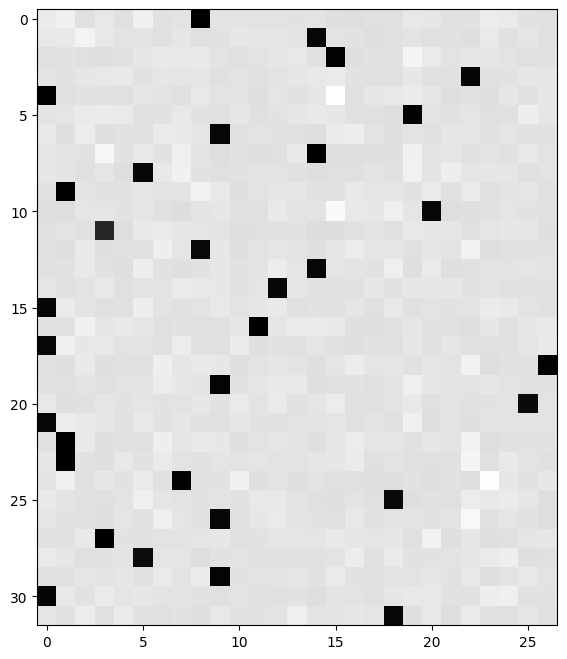

In [82]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [83]:
# negative gradient is that pushing the correct value to increase to 1
# positive gradient is that pulling the value to decrease to 0

In [85]:
# backprop through batchnorm but all in one go

hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True))/torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [86]:
# backward pass

dhprebn = bngain*bnvar_inv/n*(n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [96]:
# complete

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g)*0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.1
b2 = torch.randn(vocab_size, generator = g)*0.1

# Batchnorm parameters
bngain = torch.randn((1, n_hidden))*0.1+1.0
bnbias = torch.randn((1, n_hidden))*0.1

# initialization with all zeros could mask an incorrect implementation for the backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
max_steps = 200000
batch_size = 32
n = batch_size
lossi = []

with torch.no_grad():

    for i in range(max_steps):

        indx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[indx], Ytr[indx]

        # forward pass

        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)

        # Linear layer 1
        hprebn = embcat @ W1 + b1

        # BatchNorm layer
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn-bnmean)*bnvar_inv
        hpreact = bngain * bnraw + bnbias

        # Non-linearity
        h = torch.tanh(hpreact)

        # Linear layer 2
        logits = h @ W2 + b2

        # cross-entropy loss
        loss = F.cross_entropy(logits, Yb)

        # PyTorch backward pass
        for p in parameters:
            p.grad = None

    #     loss.backward()

        # manual_backprop
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = (1.0 - h**2)*dh
        dbngain = (bnraw*dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n*(n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                indx = Xb[k, j]
                dC[indx] += demb[k, j]


    #     dC, dW1, db1, dW2, db2, dbgain, dbnbias = None, None, None, None, None, None, None
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        lr = 0.1 if i<100000 else 0.01
        for p, grad in zip(parameters, grads):
    #         p.data += -lr*p.grad
            p.data += -lr*grad

        if i%10000 == 0:
            print(f'{i:7d}/{max_steps}: {loss.item():.4f}')

        lossi.append(loss.log10().item())

    #     if i>=100:
    #         break

12297
      0/200000: 3.8140
  10000/200000: 2.1616
  20000/200000: 2.4172
  30000/200000: 2.4428
  40000/200000: 2.0228
  50000/200000: 2.3305
  60000/200000: 2.3267
  70000/200000: 2.0067
  80000/200000: 2.3575
  90000/200000: 2.1964
 100000/200000: 2.0072
 110000/200000: 2.2503
 120000/200000: 2.0454
 130000/200000: 2.4801
 140000/200000: 2.2223
 150000/200000: 2.1650
 160000/200000: 1.8888
 170000/200000: 1.7982
 180000/200000: 2.0190
 190000/200000: 1.8999


In [93]:
for p, g in zip(parameters, grads):
    cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.30385160446167e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(200,)          | exact: False | approximate: True  | maxdiff: 3.4924596548080444e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 2.2351741790771484e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [99]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [100]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0712292194366455
val 2.109180212020874


In [101]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
madhayla.
reisa.
jendraegelie.
kaitlie.
shi.
jenleigh.
sana.
arleigh.
malaia.
noshubergahimie.
trickennellennie.
casube.
geder.
yarleyeks.
kayshaston.
mahil.
sadyansun.
